## <font color='darkblue'><b>Preface</b></font>
([article source](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)) <b><font size='3ptx'>Time series prediction problems are a difficult type of predictive modeling problem.</font> Unlike regression predictive modeling, time series also adds the complexity of a sequence dependence among the input variables.</b>

A powerful type of neural network designed to handle sequence dependence is called a [recurrent neural network](https://machinelearningmastery.com/crash-course-recurrent-neural-networks-deep-learning/). The <b><font color='darkblue'>Long Short-Term Memory network</font></b> or <b>[LSTM network](https://en.wikipedia.org/wiki/Long_short-term_memory) is a type of recurrent neural network used in deep learning because very large architectures can be successfully trained</b>.

In this post, you will <b>discover how to develop LSTM networks in Python using the Keras deep learning library to address a demonstration time-series prediction problem</b>.

After completing this tutorial, you will know how to implement and develop LSTM networks for your own time series prediction problems and other more general sequence problems. You will know:
* About the International Airline Passengers time-series prediction problem
* How to develop LSTM networks for regression, window, and time-step-based framing of time series prediction problems
* How to develop and make predictions using LSTM networks that maintain state (memory) across very long sequences

In this tutorial, we will develop a number of LSTMs for a standard time series prediction problem. The problem and the chosen configuration for the LSTM networks are for demonstration purposes only; they are not optimized.

<b>These examples will show exactly how you can develop your own differently structured LSTM networks for time series predictive modeling problems</b>.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

### <font color='darkgreen'>Updated LSTM Time Series Forecasting Posts:</font>
The example in this post is quite dated. You can view some better examples using LSTMs on time series with:
1. [LSTMs for Univariate Time Series Forecasting](https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/)
2. [LSTMs for Multivariate Time Series Forecasting](https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/)
3. [LSTMs for Multi-Step Time Series Forecasting](https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/)

### <font color='darkgreen'>Problem Description</font>
The problem you will look at in this post is the International Airline Passengers prediction problem.

This is a problem where, given a year and a month, the task is to predict the number of international airline passengers in units of 1,000. The data ranges from January 1949 to December 1960, or 12 years, with 144 observations.
* [Download the dataset](https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv) (<font color='brown'>save as “`airline-passengers.csv`“</font>).

Below is a sample of the first few lines of the file.
```csv
"Month","Passengers"
"1949-01",112
"1949-02",118
"1949-03",132
"1949-04",129
"1949-05",121
```

You can load this dataset easily using the Pandas library. You are <b>not interested in the date, given that each observation is separated by the same interval of one month. Therefore, when you load the dataset, you can exclude the first column</b>.

Once loaded, you can easily plot the whole dataset. The code to load and plot the dataset is listed below.

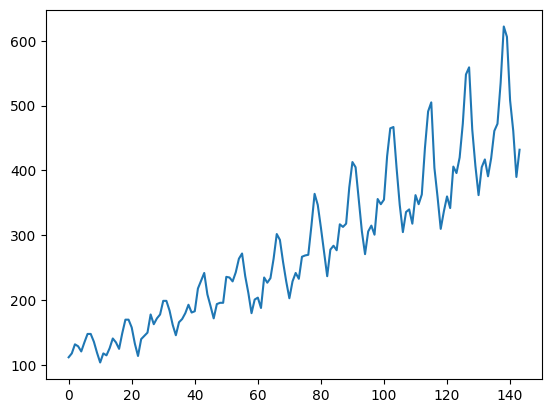

In [2]:
dataset = pd.read_csv('airline-passengers.csv', usecols=[1], engine='python')
plt.plot(dataset)
plt.show()

You can see an upward trend in the dataset over time. You can also see some periodicity in the dataset that probably corresponds to the Northern Hemisphere vacation period. Let’s keep things simple and work with the data as-is.

<b>Normally, it is a good idea to investigate various data preparation techniques to rescale the data and make it stationary.</b>

<a id='sect_lstm'></a>
## <font color='darkblue'>Long Short-Term Memory Network</font>
<b><font size='3ptx'>The [Long Short-Term Memory network](https://en.wikipedia.org/wiki/Long_short-term_memory), or LSTM network, is a recurrent neural network trained using Backpropagation Through Time that overcomes the vanishing gradient problem.</font></b>

* <font size='3ptx'><b><a href='#sect_lstm_1'>LSTM Network for Regression</a></b></font>
* <font size='3ptx'><b><a href='#sect_lstm_2'>Rudimentary LSTM model</a></b></font>
* <font size='3ptx'><b><a href='#sect_lstm_3'>LSTM for Regression Using the Window Method</a></b></font>
* <font size='3ptx'><b><a href='#sect_lstm_4'>LSTM for Regression with Time Steps</a></b></font>
* <font size='3ptx'><b><a href='#sect_lstm_5'>LSTM with Memory Between Batches</a></b></font>
* <font size='3ptx'><b><a href='#sect_lstm_6'>Stacked LSTMs with Memory Between Batches</a></b></font>


As such, it can be used to create large recurrent networks that, in turn, can be used to address difficult sequence problems in machine learning and achieve state-of-the-art results. <b>Instead of neurons, LSTM networks have memory blocks connected through layers.</b>

A block has components that make it smarter than a classical neuron and a memory for recent sequences. A block contains gates that manage the block’s state and output. A block operates upon an input sequence, and <b>each gate within a block uses the sigmoid activation units to control whether it is triggered or not, making the change of state and addition of information flowing through the block conditional</b>.

There are three types of gates within a unit:
* **Forget Gate**: conditionally decides what information to throw away from the block
* **Input Gate**: conditionally decides which values from the input to update the memory state
* **Output Gate**: conditionally decides what to output based on input and the memory of the block

Each unit is like a mini-state machine where the gates of the units have weights that are learned during the training procedure.

You can see how you may achieve sophisticated learning and memory from a layer of LSTMs, and it is not hard to imagine how higher-order abstractions may be layered with multiple such layers.

<a id='sect_lstm_1'></a>
### <font color='darkgreen'>LSTM Network for Regression</font> ([back](#sect_lstm))
<b><font size='3ptx'>You can phrase the problem as a regression problem. That is, given the number of passengers (<font color='brown'>in units of thousands</font>) this month, what is the number of passengers next month?</font></b>

You can write a simple function to <b>convert the single column of data into a two-column dataset: the first column containing this month’s (t) passenger count and the second column containing next month’s (t+1) passenger count to be predicted</b>.

Before you do anything, <b>it is a good idea to fix the random number seed to ensure your results are reproducible</b>.

In [3]:
# fix random seed for reproducibility
tf.random.set_seed(7)

You can also use the code from the previous section to load the dataset as a Pandas dataframe. You can then extract the NumPy array from the dataframe and convert the integer values to floating point values, which are more suitable for modeling with a neural network.

In [4]:
# load the dataset
dataframe = pd.read_csv('airline-passengers.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')

<b>LSTMs are sensitive to the scale of the input data, specifically when the sigmoid</b> (<font color='brown'>default</font>) <b>or tanh activation functions are used</b>. It can be a good practice to rescale the data to the range of 0-to-1, also called normalizing. You can easily normalize the dataset using the [**MinMaxScaler**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) preprocessing class from the scikit-learn library.

In [5]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

After you model the data and estimate the skill of your model on the training dataset, you need to <b>get an idea of the skill of the model on new unseen data. For a normal classification or regression problem, you would do this using cross validation</b>.

With time series data, the sequence of values is important. A simple method that you can use is to split the ordered dataset into train and test datasets. <b>The code below calculates the index of the split point and separates the data into the training datasets, with 67% of the observations used to train the model, leaving the remaining 33% for testing the model</b>.

In [6]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

96 48


Now, you can define a function to create a new dataset, as described above.

The function takes two arguments: the `dataset`, which is a NumPy array you want to convert into a dataset, and the `look_back`, which is the number of previous time steps to use as input variables to predict the next time period—in this case, defaulted to 1.

<b>This default will create a dataset where `X` is the number of passengers at a given time `(t)`, and `Y` is the number of passengers at the next time `(t + 1)`.</b> It can be configured by constructing a differently shaped dataset in the next section.

In [7]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
    
  return np.array(dataX), np.array(dataY)

Let’s take a look at the effect of this function on the first rows of the dataset (<font color='brown'>shown in the unnormalized form for clarity</font>):
```
X		Y
112		118
118		132
132		129
129		121
121		135
```

If you compare these first five rows to the original dataset sample listed in the previous section, you can see the `X=t` and `Y=t+1` pattern in the numbers. Let’s use this function to prepare the train and test datasets for modeling.

In [8]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

<b>The LSTM network expects the input data (X) to be provided with a specific array structure in the form of `[samples, time steps, features]`</b>. Currently, the data is in the form of `[samples, features]`, and you are framing the problem as one time step for each sample. You can transform the prepared train and test input data into the expected structure using [numpy.reshape()](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html) as follows:

In [9]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

You are now ready to design and fit your LSTM network for this problem.

<a id='sect_lstm_2'></a>
### <b><font color='darkgreen'>Rudimentary LSTM model</font></b> ([back](#sect_lstm))
The network has a visible layer with 1 input, a hidden layer with 4 LSTM blocks or neurons, and an output layer that makes a single value prediction. The default sigmoid activation function is used for the LSTM blocks. The network is trained for 100 epochs, and a batch size of 1 is used.

In [10]:
def lstm_model_v1():
  # create and fit the LSTM network
  model = Sequential()
  model.add(LSTM(4, input_shape=(1, look_back)))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

In [11]:
model_v1 = lstm_model_v1()
model_v1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4)                 96        
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [12]:
%%time
model_v1.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
94/94 - 1s - loss: 0.0579 - 1s/epoch - 16ms/step
Epoch 2/100
94/94 - 0s - loss: 0.0287 - 300ms/epoch - 3ms/step
Epoch 3/100
94/94 - 0s - loss: 0.0212 - 317ms/epoch - 3ms/step
Epoch 4/100
94/94 - 0s - loss: 0.0194 - 319ms/epoch - 3ms/step
Epoch 5/100
94/94 - 0s - loss: 0.0182 - 321ms/epoch - 3ms/step
Epoch 6/100
94/94 - 0s - loss: 0.0169 - 322ms/epoch - 3ms/step
Epoch 7/100
94/94 - 0s - loss: 0.0158 - 311ms/epoch - 3ms/step
Epoch 8/100
94/94 - 0s - loss: 0.0147 - 242ms/epoch - 3ms/step
Epoch 9/100
94/94 - 0s - loss: 0.0139 - 266ms/epoch - 3ms/step
Epoch 10/100
94/94 - 0s - loss: 0.0127 - 265ms/epoch - 3ms/step
Epoch 11/100
94/94 - 0s - loss: 0.0117 - 263ms/epoch - 3ms/step
Epoch 12/100
94/94 - 0s - loss: 0.0106 - 273ms/epoch - 3ms/step
Epoch 13/100
94/94 - 0s - loss: 0.0097 - 260ms/epoch - 3ms/step
Epoch 14/100
94/94 - 0s - loss: 0.0088 - 250ms/epoch - 3ms/step
Epoch 15/100
94/94 - 0s - loss: 0.0078 - 273ms/epoch - 3ms/step
Epoch 16/100
94/94 - 0s - loss: 0.0071 - 264ms/epoc

Once the model is fit, you can estimate the performance of the model on the train and test datasets. This will give you a point of comparison for new models.

Note that you will have to invert the predictions before calculating error scores (<font color='brown'>because of the normalization</font>) to ensure that performance is reported in the same units as the original data (<font color='brown'>thousands of passengers per month</font>).

In [13]:
# make predictions
trainPredict = model_v1.predict(trainX)
testPredict = model_v1.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

2/2 [==============================] - 0s 2ms/step
Train Score: 23.22 RMSE
Test Score: 49.35 RMSE


Finally, you can generate predictions using the model for both the train and test dataset to get a visual indication of the skill of the model.

Because of how the dataset was prepared, you must shift the predictions so that they align on the x-axis with the original dataset. Once prepared, <b>the data is plotted, showing the original dataset in blue, the predictions for the training dataset in green, and the predictions on the unseen test dataset in red</b>.

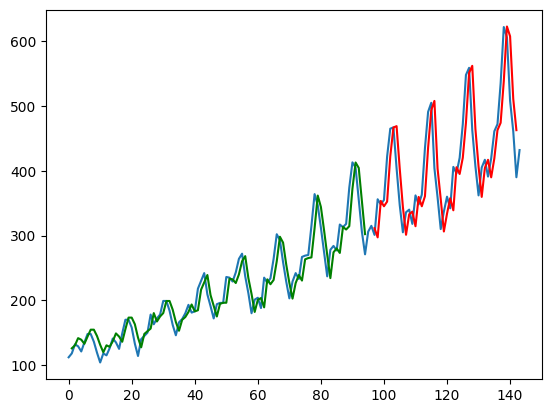

In [14]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot, fmt='g')
plt.plot(testPredictPlot, fmt='r')
plt.show()

You can see that the model did an excellent job of fitting both the training and the test datasets.

<a id='sect_lstm_3'></a>
### <font color='darkgreen'>LSTM for Regression Using the Window Method</font> ([back](#sect_lstm))
<font size='3ptx'><b>You can also phrase the problem so that multiple, recent time steps can be used to make the prediction for the next time step.</b></font>

<b>This is called a <font color='darkblue'>window</font>, and the size of the window is a parameter that can be tuned for each problem.</b> For example, given the current time `(t)` to predict the value at the next time in the sequence `(t+1)`, you can use the current time `(t)`, as well as the two prior times `(t-1 and t-2)` as input variables.

When phrased as a regression problem, the input variables are t-2, t-1, and t, and the output variable is t+1.

The <font color='blue'>create_dataset()</font> function created in the previous section allows you to create this formulation of the time series problem by increasing the `look_back` argument from 1 to 3. A sample of the dataset with this formulation is as follows:
```
X1	X2	X3	Y
112	118	132	129
118	132	129	121
132	129	121	135
129	121	135	148
121	135	148	148
```

You can re-run the example in the previous section with the larger window size. The whole code listing with just the window size change is listed below for completeness.

In [15]:
def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
    
  return np.array(dataX), np.array(dataY)

In [17]:
# load the dataset
dataframe = pd.read_csv('airline-passengers.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')

In [24]:
print(dataset.shape)
dataset[:3]

(144, 1)


array([[0.01544401],
       [0.02702703],
       [0.05405405]], dtype=float32)

In [20]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [23]:
dataset[:3]

array([[0.01544401],
       [0.02702703],
       [0.05405405]], dtype=float32)

In [21]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [22]:
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [26]:
print(trainX.shape)
trainX[:3]

(92, 1, 3)


array([[[0.01544401, 0.02702703, 0.05405405]],

       [[0.02702703, 0.05405405, 0.04826255]],

       [[0.05405405, 0.04826255, 0.03281853]]], dtype=float32)

In [25]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [32]:
# create and fit the LSTM network
def create_model(look_back, time_steps=1, units=4):
  """Creates LSTM model.
  
  For details of LSTM layer, refer to:
  - https://keras.io/api/layers/recurrent_layers/lstm/
  
  Args:
    look_back: Look back of time series data. One of input shape pyrid.
    time_steps: One input shape pyrid.
    units: LSTM layer parameter. Positive integer, dimensionality of the output space.
  """
  model = Sequential()
  model.add(LSTM(units, input_shape=(time_steps, look_back)))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

In [33]:
model_v2 = create_model(look_back)
model_v2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 4)                 128       
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 133
Trainable params: 133
Non-trainable params: 0
_________________________________________________________________


In [34]:
%%time
model_v2.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
92/92 - 1s - loss: 0.0415 - 1s/epoch - 15ms/step
Epoch 2/100
92/92 - 0s - loss: 0.0172 - 316ms/epoch - 3ms/step
Epoch 3/100
92/92 - 0s - loss: 0.0116 - 311ms/epoch - 3ms/step
Epoch 4/100
92/92 - 0s - loss: 0.0100 - 312ms/epoch - 3ms/step
Epoch 5/100
92/92 - 0s - loss: 0.0088 - 303ms/epoch - 3ms/step
Epoch 6/100
92/92 - 0s - loss: 0.0078 - 304ms/epoch - 3ms/step
Epoch 7/100
92/92 - 0s - loss: 0.0068 - 310ms/epoch - 3ms/step
Epoch 8/100
92/92 - 0s - loss: 0.0060 - 305ms/epoch - 3ms/step
Epoch 9/100
92/92 - 0s - loss: 0.0052 - 301ms/epoch - 3ms/step
Epoch 10/100
92/92 - 0s - loss: 0.0046 - 302ms/epoch - 3ms/step
Epoch 11/100
92/92 - 0s - loss: 0.0042 - 307ms/epoch - 3ms/step
Epoch 12/100
92/92 - 0s - loss: 0.0040 - 308ms/epoch - 3ms/step
Epoch 13/100
92/92 - 0s - loss: 0.0037 - 311ms/epoch - 3ms/step
Epoch 14/100
92/92 - 0s - loss: 0.0037 - 301ms/epoch - 3ms/step
Epoch 15/100
92/92 - 0s - loss: 0.0036 - 297ms/epoch - 3ms/step
Epoch 16/100
92/92 - 0s - loss: 0.0034 - 276ms/epoc

In [36]:
# make predictions
trainPredict = model_v2.predict(trainX)
testPredict = model_v2.predict(testX)

2/2 [==============================] - 0s 2ms/step


In [37]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [39]:
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 22.26 RMSE
Test Score: 64.85 RMSE


In [40]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

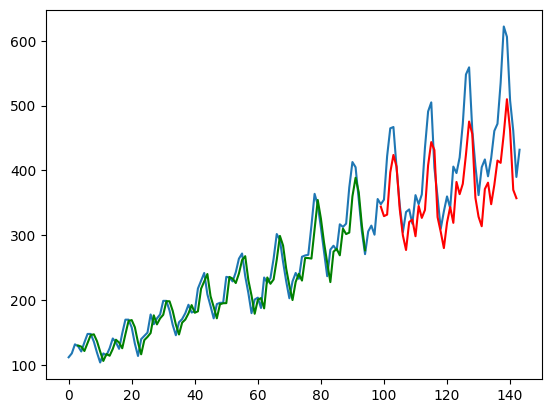

In [43]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot, 'g')
plt.plot(testPredictPlot, 'r')
plt.show()

<b>You can see that the error was increased slightly compared to that of the previous section. The window size and the network architecture were not tuned</b>: This is just a demonstration of how to frame a prediction problem.

<a id='sect_lstm_4'></a>
### <font color='darkgreen'>LSTM for Regression with Time Steps</font> ([back](#sect_lstm))
<b><font size='3ptx'>You may have noticed that the data preparation for the LSTM network includes time steps.</font></b>

<b>Some sequence problems may have a varied number of time steps per sample</b>. For example, you may have measurements of a physical machine leading up to the point of failure or a point of surge. Each incident would be a sample of observations that lead up to the event, which would be the time steps, and the variables observed would be the features.

Time steps provide another way to phrase your time series problem. Like above in the window example, you can take prior time steps in your time series as inputs to predict the output at the next time step.

<b>Instead of phrasing the past observations as separate input features, you can use them as time steps of the one input feature, which is indeed a more accurate framing of the problem</b>.

You can do this using the same data representation as in the previous window-based example, except when you reshape the data, you set the columns to be the time steps dimension and change the features dimension back to 1. For example:
```python
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
```

The entire code listing is provided below for completeness.

In [44]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [45]:
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [46]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [49]:
# create and fit the LSTM network
def create_model(look_back, units=4):
  """Creates LSTM model.
  
  For details of LSTM layer, refer to:
  - https://keras.io/api/layers/recurrent_layers/lstm/
  
  Args:
    look_back: Look back of time series data. One of input shape pyrid.
    time_steps: One input shape pyrid.
    units: LSTM layer parameter. Positive integer, dimensionality of the output space.
  """
  model = Sequential()
  model.add(LSTM(units, input_shape=(look_back, 1)))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

In [50]:
# create LSTM network
model_v3 = create_model(look_back)
model_v3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 4)                 96        
                                                                 
 dense_5 (Dense)             (None, 1)                 5         
                                                                 
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [51]:
%%time
model_v3.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
92/92 - 1s - loss: 0.0322 - 1s/epoch - 16ms/step
Epoch 2/100
92/92 - 0s - loss: 0.0125 - 400ms/epoch - 4ms/step
Epoch 3/100
92/92 - 0s - loss: 0.0103 - 400ms/epoch - 4ms/step
Epoch 4/100
92/92 - 0s - loss: 0.0092 - 396ms/epoch - 4ms/step
Epoch 5/100
92/92 - 0s - loss: 0.0080 - 389ms/epoch - 4ms/step
Epoch 6/100
92/92 - 0s - loss: 0.0071 - 376ms/epoch - 4ms/step
Epoch 7/100
92/92 - 0s - loss: 0.0062 - 399ms/epoch - 4ms/step
Epoch 8/100
92/92 - 0s - loss: 0.0056 - 397ms/epoch - 4ms/step
Epoch 9/100
92/92 - 0s - loss: 0.0048 - 395ms/epoch - 4ms/step
Epoch 10/100
92/92 - 0s - loss: 0.0044 - 395ms/epoch - 4ms/step
Epoch 11/100
92/92 - 0s - loss: 0.0042 - 376ms/epoch - 4ms/step
Epoch 12/100
92/92 - 0s - loss: 0.0041 - 364ms/epoch - 4ms/step
Epoch 13/100
92/92 - 0s - loss: 0.0040 - 395ms/epoch - 4ms/step
Epoch 14/100
92/92 - 0s - loss: 0.0041 - 387ms/epoch - 4ms/step
Epoch 15/100
92/92 - 0s - loss: 0.0040 - 392ms/epoch - 4ms/step
Epoch 16/100
92/92 - 0s - loss: 0.0038 - 394ms/epoc

In [53]:
# make predictions
trainPredict = model_v3.predict(trainX)
testPredict = model_v3.predict(testX)

2/2 [==============================] - 0s 3ms/step


In [54]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [55]:
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 27.83 RMSE
Test Score: 63.59 RMSE


In [56]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

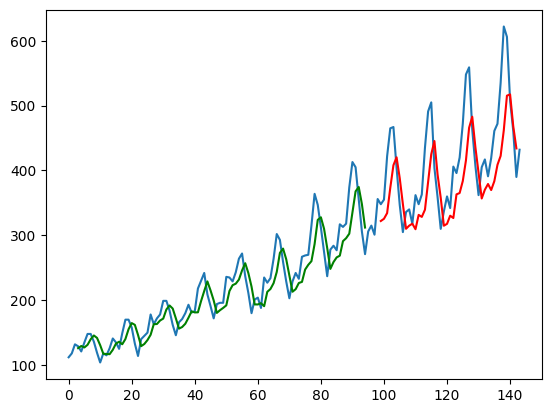

In [57]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot, 'g')
plt.plot(testPredictPlot, 'r')
plt.show()

You can see that the results are slightly better than the previous example, although the structure of the input data makes a lot more sense.

<a id='sect_lstm_5'></a>
### <b><font color='darkgreen'>LSTM with Memory Between Batches</font></b> ([back](#sect_lstm))
<b><font size='3ptx'>The LSTM network has memory capable of remembering across long sequences.</font></b>

<b>Normally, the state within the network is reset after each training batch when fitting the model, as well as each call to <font color='blue'>model.predict()</font> or <font color='blue'>model.evaluate()</font></b>. 

<b>You can gain finer control over when the internal state of the LSTM network is cleared in Keras by making the LSTM layer “stateful.”</b> This means it can build a state over the entire training sequence and even maintain that state if needed to make predictions.

<b>It requires that the training data not be shuffled when fitting the network. It also requires explicit resetting of the network state after each exposure to the training data</b> (<font color='brown'>epoch</font>) <b>by calls to <font color='blue'>model.reset_states()</font></b>. This means that you must create your own outer loop of epochs and within each epoch call <font color='blue'>model.fit()</font> and <font color='blue'>model.reset_states()</font>. For example:
```python
for i in range(100):
	model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
	model.reset_states()
```

Finally, when the LSTM layer is constructed, the `stateful` parameter must be set to True. Instead of specifying the input dimensions, you must hard code the number of samples in a batch, the number of time steps in a sample, and the number of features in a time step by setting the `batch_input_shape` parameter. For example:
```python
model.add(LSTM(4, batch_input_shape=(batch_size, time_steps, features), stateful=True))
```

This same `batch_size` must then be used later when evaluating the model and making predictions. For example:
```python
model.predict(trainX, batch_size=batch_size)
```

You can adapt the previous time step example to use a stateful LSTM. The full code listing is provided below.

In [79]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [80]:
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [81]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [82]:
# Create and fit the LSTM network
def create_stateful_model(batch_size = 1, units=4):
  batch_size = 1
  model = Sequential()
  model.add(LSTM(units, batch_input_shape=(batch_size, look_back, 1), stateful=True))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

In [83]:
batch_size = 1
model_v4 = create_stateful_model(batch_size=batch_size)
model_v4.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (1, 4)                    96        
                                                                 
 dense_10 (Dense)            (1, 1)                    5         
                                                                 
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [84]:
%%time
for i in range(200):
  model_v4.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
  model_v4.reset_states()

92/92 - 1s - loss: 0.0111 - 1s/epoch - 16ms/step
92/92 - 0s - loss: 0.0234 - 387ms/epoch - 4ms/step
92/92 - 0s - loss: 0.0127 - 391ms/epoch - 4ms/step
92/92 - 0s - loss: 0.0089 - 392ms/epoch - 4ms/step
92/92 - 0s - loss: 0.0069 - 361ms/epoch - 4ms/step
92/92 - 0s - loss: 0.0057 - 380ms/epoch - 4ms/step
92/92 - 0s - loss: 0.0051 - 394ms/epoch - 4ms/step
92/92 - 0s - loss: 0.0048 - 381ms/epoch - 4ms/step
92/92 - 0s - loss: 0.0047 - 393ms/epoch - 4ms/step
92/92 - 0s - loss: 0.0046 - 398ms/epoch - 4ms/step
92/92 - 0s - loss: 0.0045 - 385ms/epoch - 4ms/step
92/92 - 0s - loss: 0.0044 - 390ms/epoch - 4ms/step
92/92 - 0s - loss: 0.0044 - 401ms/epoch - 4ms/step
92/92 - 0s - loss: 0.0044 - 386ms/epoch - 4ms/step
92/92 - 0s - loss: 0.0043 - 388ms/epoch - 4ms/step
92/92 - 0s - loss: 0.0043 - 394ms/epoch - 4ms/step
92/92 - 0s - loss: 0.0043 - 381ms/epoch - 4ms/step
92/92 - 0s - loss: 0.0042 - 390ms/epoch - 4ms/step
92/92 - 0s - loss: 0.0042 - 391ms/epoch - 4ms/step
92/92 - 0s - loss: 0.0042 - 382ms

92/92 - 0s - loss: 0.0021 - 335ms/epoch - 4ms/step
92/92 - 0s - loss: 0.0021 - 332ms/epoch - 4ms/step
92/92 - 0s - loss: 0.0021 - 336ms/epoch - 4ms/step
92/92 - 0s - loss: 0.0021 - 336ms/epoch - 4ms/step
92/92 - 0s - loss: 0.0021 - 347ms/epoch - 4ms/step
92/92 - 0s - loss: 0.0021 - 368ms/epoch - 4ms/step
92/92 - 0s - loss: 0.0021 - 336ms/epoch - 4ms/step
92/92 - 0s - loss: 0.0021 - 333ms/epoch - 4ms/step
92/92 - 0s - loss: 0.0021 - 333ms/epoch - 4ms/step
92/92 - 0s - loss: 0.0021 - 313ms/epoch - 3ms/step
92/92 - 0s - loss: 0.0021 - 256ms/epoch - 3ms/step
92/92 - 0s - loss: 0.0021 - 329ms/epoch - 4ms/step
92/92 - 0s - loss: 0.0021 - 368ms/epoch - 4ms/step
92/92 - 0s - loss: 0.0021 - 356ms/epoch - 4ms/step
92/92 - 0s - loss: 0.0021 - 325ms/epoch - 4ms/step
92/92 - 0s - loss: 0.0020 - 311ms/epoch - 3ms/step
92/92 - 0s - loss: 0.0020 - 326ms/epoch - 4ms/step
92/92 - 0s - loss: 0.0020 - 310ms/epoch - 3ms/step
92/92 - 0s - loss: 0.0020 - 314ms/epoch - 3ms/step
92/92 - 0s - loss: 0.0020 - 336

In [71]:
# make predictions
trainPredict = model_v4.predict(trainX, batch_size=batch_size)
model_v4.reset_states()
testPredict = model_v4.predict(testX, batch_size=batch_size)

44/44 [==============================] - 0s 2ms/step


In [72]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [73]:
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 27.98 RMSE
Test Score: 67.36 RMSE


In [74]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

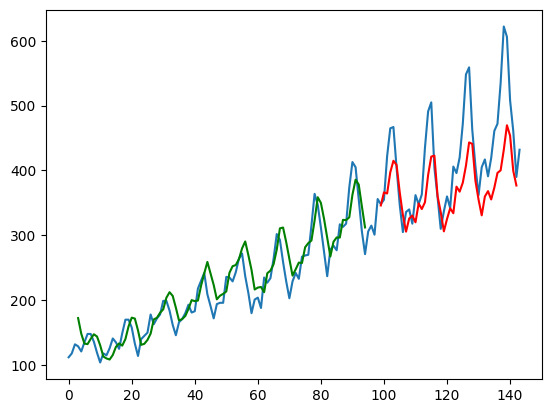

In [75]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot, 'g')
plt.plot(testPredictPlot, 'r')
plt.show()

You do see that results are better than some, worse than others. The model may need more modules and may need to be trained for more epochs to internalize the structure of the problem.

<a id='sect_lstm_6'></a>
### <font color='darkgreen'>Stacked LSTMs with Memory Between Batches</font> ([back](#sect_lstm))
<b><font size='3ptx'>Finally, let’s take a look at one of the big benefits of LSTMs: the fact that they can be successfully trained when stacked into deep network architectures.</font></b>

LSTM networks can be stacked in Keras in the same way that other layer types can be stacked. One addition to the configuration that is required is that an LSTM layer prior to each subsequent LSTM layer must return the sequence. 

<b>This can be done by setting the <font color='violet'>return_sequences</font> parameter on the layer to True.</b>

You can extend the stateful LSTM in the previous section to have two layers, as follows:
```python
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
```

The entire code listing is provided below for completeness.

In [97]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [98]:
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [99]:
# Create and fit the LSTM network
batch_size = 1
def create_stateful_and_stacked_model(batch_size):
  model = Sequential()
  model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
  model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

In [100]:
model_v5 = create_stateful_and_stacked_model(batch_size)
model_v5.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (1, 3, 4)                 96        
                                                                 
 lstm_14 (LSTM)              (1, 4)                    144       
                                                                 
 dense_12 (Dense)            (1, 1)                    5         
                                                                 
Total params: 245
Trainable params: 245
Non-trainable params: 0
_________________________________________________________________


In [101]:
%%time
for i in range(200):
  model_v5.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
  model_v5.reset_states()

92/92 - 3s - loss: 0.0049 - 3s/epoch - 29ms/step
92/92 - 1s - loss: 0.0107 - 625ms/epoch - 7ms/step
92/92 - 1s - loss: 0.0076 - 648ms/epoch - 7ms/step
92/92 - 1s - loss: 0.0064 - 650ms/epoch - 7ms/step
92/92 - 1s - loss: 0.0059 - 647ms/epoch - 7ms/step
92/92 - 1s - loss: 0.0057 - 647ms/epoch - 7ms/step
92/92 - 1s - loss: 0.0057 - 648ms/epoch - 7ms/step
92/92 - 1s - loss: 0.0056 - 634ms/epoch - 7ms/step
92/92 - 1s - loss: 0.0056 - 628ms/epoch - 7ms/step
92/92 - 1s - loss: 0.0056 - 653ms/epoch - 7ms/step
92/92 - 1s - loss: 0.0056 - 640ms/epoch - 7ms/step
92/92 - 1s - loss: 0.0056 - 620ms/epoch - 7ms/step
92/92 - 1s - loss: 0.0056 - 634ms/epoch - 7ms/step
92/92 - 1s - loss: 0.0056 - 631ms/epoch - 7ms/step
92/92 - 1s - loss: 0.0056 - 638ms/epoch - 7ms/step
92/92 - 1s - loss: 0.0056 - 645ms/epoch - 7ms/step
92/92 - 1s - loss: 0.0055 - 610ms/epoch - 7ms/step
92/92 - 1s - loss: 0.0055 - 642ms/epoch - 7ms/step
92/92 - 1s - loss: 0.0055 - 643ms/epoch - 7ms/step
92/92 - 1s - loss: 0.0055 - 634ms

92/92 - 1s - loss: 0.0017 - 649ms/epoch - 7ms/step
92/92 - 1s - loss: 0.0017 - 640ms/epoch - 7ms/step
92/92 - 1s - loss: 0.0016 - 642ms/epoch - 7ms/step
92/92 - 1s - loss: 0.0016 - 610ms/epoch - 7ms/step
92/92 - 1s - loss: 0.0016 - 633ms/epoch - 7ms/step
92/92 - 1s - loss: 0.0016 - 640ms/epoch - 7ms/step
92/92 - 1s - loss: 0.0016 - 635ms/epoch - 7ms/step
92/92 - 1s - loss: 0.0016 - 647ms/epoch - 7ms/step
92/92 - 1s - loss: 0.0016 - 635ms/epoch - 7ms/step
92/92 - 1s - loss: 0.0015 - 627ms/epoch - 7ms/step
92/92 - 1s - loss: 0.0015 - 633ms/epoch - 7ms/step
92/92 - 1s - loss: 0.0015 - 625ms/epoch - 7ms/step
92/92 - 1s - loss: 0.0015 - 630ms/epoch - 7ms/step
92/92 - 1s - loss: 0.0015 - 640ms/epoch - 7ms/step
92/92 - 1s - loss: 0.0015 - 645ms/epoch - 7ms/step
92/92 - 1s - loss: 0.0014 - 642ms/epoch - 7ms/step
92/92 - 1s - loss: 0.0014 - 641ms/epoch - 7ms/step
92/92 - 1s - loss: 0.0014 - 641ms/epoch - 7ms/step
92/92 - 1s - loss: 0.0013 - 629ms/epoch - 7ms/step
92/92 - 1s - loss: 0.0015 - 645

In [102]:
# make predictions
trainPredict = model_v5.predict(trainX, batch_size=batch_size)
model_v5.reset_states()
testPredict = model_v5.predict(testX, batch_size=batch_size)

44/44 [==============================] - 0s 3ms/step


In [103]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [104]:
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 21.67 RMSE
Test Score: 62.43 RMSE


In [105]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

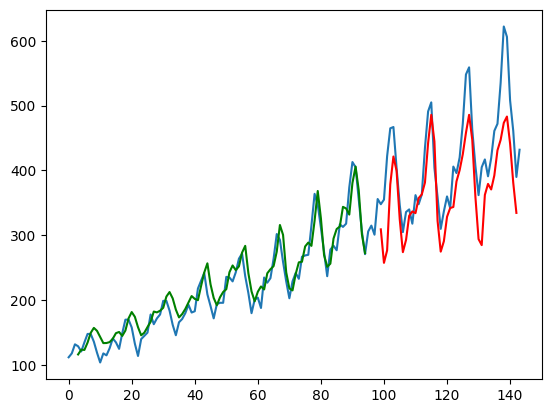

In [106]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot, 'g')
plt.plot(testPredictPlot, 'r')
plt.show()

## <font color='darkblue'>Summary</font>
In this post, you discovered how to develop LSTM recurrent neural networks for time series prediction in Python with the Keras deep learning network. Specifically, you learned:
* About the international airline passenger time series prediction problem
* How to create an LSTM for a regression and a window formulation of the time series problem
* How to create an LSTM with a time step formulation of the time series problem
* How to create an LSTM with state and stacked LSTMs with state to learn long sequences

### <font color='darkgreen'>Updated LSTM Time Series Forecasting Posts:</font>
The example in this post is quite dated. See these better examples available for using LSTMs on time series:
1. [LSTMs for Univariate Time Series Forecasting](https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/)
2. [LSTMs for Multivariate Time Series Forecasting](https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/)
3. [LSTMs for Multi-Step Time Series Forecasting](https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/)

## <font color='darkblue'>Supplement</font>
* [Stackoverflow - Disable Tensorflow debugging information](https://stackoverflow.com/questions/35911252/disable-tensorflow-debugging-information)